# Videogame sales, classification and prediction 
(work in progress)
## Deep learning
I will build a model to predict the sales of a game based on its name, console, genre, year and publisher, and whether or not it will win an award, using a X input and two outputs keras model

In [ ]:
import pandas as pd
import numpy as np
from numpy import unique
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, Dropout, Concatenate
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import plot_model


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/data_for_colab/vgsales.xlsx")
# First glimpse into the dataset
df.head()

,Name,Console,Year,Genre,Publisher,NorthAmerica_Sales,Europe_Sales,Japan_Sales,RestofWorld_Sales,Total_Sales,Consumer_rating,Won_an_award
0,2002 FIFA World Cup,PS2,year 2002,Sports,Electronic Arts,0.21,0.17,0.16,0.06,0.59,79,did not win
1,2002 FIFA World Cup,XB,year 2002,Sports,Electronic Arts,0.14,0.04,0.00,0.01,0.19,40,did not win
2,2002 FIFA World Cup,GC,year 2002,Sports,Electronic Arts,0.04,0.01,0.00,0.00,0.05,28,did not win
3,2010 FIFA World Cup South Africa,PS3,year 2010,Sports,Electronic Arts,0.30,0.64,0.07,0.22,1.23,82,won
4,2010 FIFA World Cup South Africa,X360,year 2010,Sports,Electronic Arts,0.32,0.43,0.02,0.09,0.86,52,did not win


In [ ]:
df.describe()
# in Japan sales, its not possible to have negative sales therefore i need to correct that column

,NorthAmerica_Sales,Europe_Sales,Japan_Sales,RestofWorld_Sales,Total_Sales,Consumer_rating
count,16591.000000,15984.000000,16622.000000,16225.000000,16241.000000,16622.00000
mean,0.262971,0.154686,0.034845,0.049255,0.550436,38.64932
std,0.822267,0.573460,1.920738,0.190720,1.573293,25.61324
min,0.000000,0.000000,-123.000000,0.000000,0.010000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.070000,17.00000
50%,0.080000,0.020000,0.000000,0.010000,0.180000,36.00000
75%,0.240000,0.120000,0.040000,0.040000,0.490000,59.00000
max,41.490000,29.020000,10.220000,10.570000,82.740000,100.00000


In [ ]:
# Using mask to change the values lower than 0 to nans
df["Japan_Sales"] = df["Japan_Sales"].mask(df["Japan_Sales"] < 0)
# Obtain minimum value from the column, it should be 0
df["Japan_Sales"].min()

0.0

In [ ]:
# Check the datatypes of the columns
print(df.dtypes)
#Drop the duplicates (if we have any)
df.drop_duplicates(inplace=True)
# We have mistaken datatypes and many na's

Name                   object
Console                object
Year                   object
Genre                  object
Publisher              object
NorthAmerica_Sales    float64
Europe_Sales          float64
Japan_Sales           float64
RestofWorld_Sales     float64
Total_Sales           float64
Consumer_rating         int64
Won_an_award           object
dtype: object


In [ ]:
# correcting the year datatype
df['Year'] = pd.to_numeric(df['Year'].str.replace('year', ''))
print(df["Year"].dtypes)

float64


In [ ]:
df2 = df[["Console","Genre","Publisher", "Won_an_award","Name"]]
for column in df2:
  print( column, "unique values:" ,df[column].unique())

Console unique values: ['PS2' 'XB' 'GC' 'PS3' 'X360' 'PSP' 'Wii' 'DS' 'N64' 'NES' 'PC' 'PS' '3DS'
 'GBA' 'PSV' 'PS4' 'XOne' 'SNES' 2600 'WiiU' 'SAT' 'GB' 'NG' 'GEN' 'PCFX'
 'DC' '3DO' 'WS' 'TG16' 'SCD' 'GG']
Genre unique values: ['     Sports' 'Sports' 'Adventure' 'Shooter' 'Role-Playing' 'Action'
 '   Action' 'Racing' 'Misc' '     Puzzle' 'Simulation' 'Platform'
 'Puzzle' 'Strategy' 'Fighting']
Publisher unique values: ['Electronic Arts' 'Capcom' 'Quinrose' 'GT Interactive'
 'Namco Bandai Games' 'Atari' 'Activision' 'DSI Games' 'Kaga Create'
 'Ubisoft' 'nintendo' 'Rondomedia' 'Nintendo' 'Avanquest' 'Nordcurrent'
 '5pb' 'CyberFront' 'Happinet' 'DTP Entertainment' 'Deep Silver'
 'Acclaim Entertainment' 'THQ' 'Sega' 'Sony Computer Entertainment'
 'Eidos Interactive' 'Warner Bros. Interactive Entertainment'
 'BMG Interactive Entertainment' 'SouthPeak Games' 'Psygnosis'
 'Avalon Interactive' '989 Studios' 'Mastertronic' 'Spike'
 'Gathering of Developers' 'Vivendi Games' 'Destineer'
 'Avanq

In [ ]:
# In the genre column we have duplicated values, action and puzzle appear four times
df["Genre"] = df["Genre"].str.strip()
# Checking the correction
df["Genre"].unique()

array(['Sports', 'Adventure', 'Shooter', 'Role-Playing', 'Action',
       'Racing', 'Misc', 'Puzzle', 'Simulation', 'Platform', 'Strategy',
       'Fighting'], dtype=object)

In [ ]:
#Check the Na's in the dataframe
# Creating a function to check them
def na_status(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent_1 = df.isnull().sum()/df.isnull().count()*100
  percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
  missing_data = pd.concat([total, percent_2], axis=1, keys=['Total NaN', 'NaN %'])
  print(missing_data.head(10))
# Appliying the function to the df
na_status(df)

                    Total NaN  NaN %
Europe_Sales              638    3.8
RestofWorld_Sales         397    2.4
Total_Sales               381    2.3
Year                      271    1.6
Publisher                  58    0.3
Japan_Sales                49    0.3
NorthAmerica_Sales         31    0.2
Won_an_award                0    0.0
Consumer_rating             0    0.0
Genre                       0    0.0


In [ ]:
# instance of label encoder
encoder = LabelEncoder()

# Encoding the columns
df["Publisher"] = df["Publisher"].replace(np.nan, "missingvalue")
# Encoding the publisher column
df["Publisher"] = encoder.fit_transform(df["Publisher"])
# Creating a dictionary to find the key of missingvalue
mapping = dict(zip(encoder.classes_, range(len(encoder.classes_)))) 
print(mapping) # Missingvalue its encoded as 578
# Replacing 578 to np.nan
df["Publisher"] = df["Publisher"].replace(578, np.nan) 

# Encoding the other columns
df["Genre"] = encoder.fit_transform(df["Genre"])
df["Won_an_award"] = encoder.fit_transform(df["Won_an_award"])
df["Name"] = encoder.fit_transform(df["Name"].astype(str))
df["Console"] = encoder.fit_transform(df["Console"].astype(str))
df["Console"].astype("category")
# Unique values in the columns
for column in df2:
  print( column, "unique values:" ,df[column].unique())

{'10TACLE Studios': 0, '1C Company': 1, '20th Century Fox Video Games': 2, '2D Boy': 3, '3DO': 4, '49Games': 5, '505 Games': 6, '5pb': 7, '7G//AMES': 8, '989 Sports': 9, '989 Studios': 10, 'AQ Interactive': 11, 'ASC Games': 12, 'ASCII Entertainment': 13, 'ASCII Media Works': 14, 'ASK': 15, 'Abylight': 16, 'Acclaim Entertainment': 17, 'Accolade': 18, 'Ackkstudios': 19, 'Acquire': 20, 'Activision': 21, 'Activision Blizzard': 22, 'Activision Value': 23, 'Adeline Software': 24, 'Aerosoft': 25, 'Agatsuma Entertainment': 26, 'Agetec': 27, 'Aksys Games': 28, 'Alawar Entertainment': 29, 'Alchemist': 30, 'Alternative Software': 31, 'Altron': 32, 'Alvion': 33, 'American Softworks': 34, 'Angel Studios': 35, 'Answer Software': 36, 'Aqua Plus': 37, 'Aques': 38, 'Arc System Works': 39, 'Arena Entertainment': 40, 'Aria': 41, 'Arika': 42, 'ArtDink': 43, 'Aruze Corp': 44, 'Ascaron Entertainment': 45, 'Ascaron Entertainment GmbH': 46, 'Asgard': 47, 'Asmik Ace Entertainment': 48, 'Asmik Corp': 49, 'Aspyr

# Imputation

In [ ]:
# Imputing the missing values
#Instance of Knn imputer
imp = KNNImputer(n_neighbors=12)

# Imputing the df, i kept the columns in df_columns
df_columns = df.columns
df = pd.DataFrame(imp.fit_transform(df), columns=df_columns)
df.head()

,Name,Console,Year,Genre,Publisher,NorthAmerica_Sales,Europe_Sales,Japan_Sales,RestofWorld_Sales,Total_Sales,Consumer_rating,Won_an_award
0,49.0,16.0,2002.0,10.0,138.0,0.21,0.17,0.16,0.06,0.59,79.0,0.0
1,49.0,29.0,2002.0,10.0,138.0,0.14,0.04,0.00,0.01,0.19,40.0,0.0
2,49.0,7.0,2002.0,10.0,138.0,0.04,0.01,0.00,0.00,0.05,28.0,0.0
3,50.0,17.0,2010.0,10.0,138.0,0.30,0.64,0.07,0.22,1.23,82.0,1.0
4,50.0,28.0,2010.0,10.0,138.0,0.32,0.43,0.02,0.09,0.86,52.0,0.0


In [ ]:
#Checking if there are any na's left
na_status(df)

                    Total NaN  NaN %
Won_an_award                0    0.0
Consumer_rating             0    0.0
Total_Sales                 0    0.0
RestofWorld_Sales           0    0.0
Japan_Sales                 0    0.0
Europe_Sales                0    0.0
NorthAmerica_Sales          0    0.0
Publisher                   0    0.0
Genre                       0    0.0
Year                        0    0.0


In [ ]:
df

,Name,Console,Year,Genre,Publisher,NorthAmerica_Sales,Europe_Sales,Japan_Sales,RestofWorld_Sales,Total_Sales,Consumer_rating,Won_an_award
0,49.0,16.0,2002.0,10.0,138.0,0.21,0.170000,0.16,0.06,0.59,79.0,0.0
1,49.0,29.0,2002.0,10.0,138.0,0.14,0.040000,0.00,0.01,0.19,40.0,0.0
2,49.0,7.0,2002.0,10.0,138.0,0.04,0.010000,0.00,0.00,0.05,28.0,0.0
3,50.0,17.0,2010.0,10.0,138.0,0.30,0.640000,0.07,0.22,1.23,82.0,1.0
4,50.0,28.0,2010.0,10.0,138.0,0.32,0.430000,0.02,0.09,0.86,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16610,11464.0,28.0,2012.0,10.0,6.0,0.00,0.394167,0.00,0.02,0.19,57.0,0.0
16611,11465.0,26.0,2013.0,3.0,297.0,0.14,0.110000,0.00,0.03,0.27,60.0,0.0
16612,11465.0,30.0,2013.0,3.0,297.0,0.17,0.050000,0.00,0.02,0.23,59.0,0.0
16613,11466.0,19.0,2008.0,7.0,156.0,0.00,0.000000,0.02,0.00,0.02,14.0,0.0


Now i will build a model to predict the sales of a game based on its console, genre, year and publisher, and wether or not it will win an award

---



In [ ]:
# Splitting the data into training and validation sets
vg_train, vg_test = train_test_split(df, test_size = .25, random_state = 42)

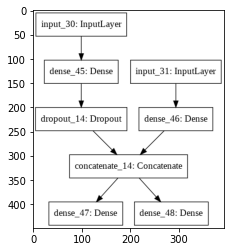

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 120)          240         input_30[0][0]                   
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 120)          0           dense_45[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Creating the layers
input_sales = Input(shape=(1,))
lstm1 = Dense(120)(input_sales)
dropout = Dropout(rate=0.2)(lstm1)

input_console = Input(shape=(1,))
dense2 = Dense(100)(input_console)

dense1 = Concatenate()([dropout,dense2])
output1 = Dense(1)(dense1)
output2 = Dense(1, activation="sigmoid")(dense1)

#input3 = Input(shape=(1,))
#input4 = Input(shape=(1,))

#output1 = Dense(1)
#output2 = Dense(1)

loss = ["mean_absolute_error"]
model = Model(
    [input_sales, input_console],
    [output1,output2])

# Plot the model
plot_model(model, to_file="model.png")
# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

model.compile(optimizer="adam", loss= ["mean_absolute_error", "binary_crossentropy"])
model.summary()

In [ ]:
# Fitting the model in sales and console columns
model.fit(
    [ #Inputs
     vg_train["Total_Sales"], vg_train["Console"]
     ],
    # Output 
    [
     vg_train["Total_Sales"], vg_train["Won_an_award"]
     ],
    epochs=20,
    verbose=True,
    validation_split=.1,
    batch_size=128)

Epoch 1/20
88/88 [==============================] - 1s 5ms/step - loss: 0.4470 - dense_47_loss: 0.3337 - dense_48_loss: 0.1134 - val_loss: 0.1194 - val_dense_47_loss: 0.0183 - val_dense_48_loss: 0.1011
Epoch 2/20
88/88 [==============================] - 0s 3ms/step - loss: 0.1378 - dense_47_loss: 0.0424 - dense_48_loss: 0.0954 - val_loss: 0.1088 - val_dense_47_loss: 0.0166 - val_dense_48_loss: 0.0922
Epoch 3/20
88/88 [==============================] - 0s 3ms/step - loss: 0.1257 - dense_47_loss: 0.0423 - dense_48_loss: 0.0834 - val_loss: 0.0880 - val_dense_47_loss: 0.0057 - val_dense_48_loss: 0.0824
Epoch 4/20
88/88 [==============================] - 0s 3ms/step - loss: 0.1236 - dense_47_loss: 0.0450 - dense_48_loss: 0.0787 - val_loss: 0.0830 - val_dense_47_loss: 0.0093 - val_dense_48_loss: 0.0738
Epoch 5/20
88/88 [==============================] - 0s 3ms/step - loss: 0.0972 - dense_47_loss: 0.0332 - dense_48_loss: 0.0640 - val_loss: 0.0753 - val_dense_47_loss: 0.0122 - val_dense_48_los

In [ ]:
print(model.evaluate(
    # inputs
    [vg_test["Total_Sales"], vg_test["Console"]],
    #Outputs
    [vg_test["Total_Sales"], vg_test["Won_an_award"]])
)

130/130 [==============================] - 0s 1ms/step - loss: 0.0730 - dense_47_loss: 0.0390 - dense_48_loss: 0.0340
[0.07302908599376678, 0.03904277831315994, 0.03398629650473595]
